In [1]:
import os
import time
import sys
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import f1_score

VERI_DOSYASI = r'C:\Users\beytu\BitkiProjesi\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv'
ANA_KLASOR = r'C:\Users\beytu\BitkiProjesi\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train'

BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCH_SAYISI = 15
RESIM_BOYUTU = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n==========================================")
print("--- BEYTULLAH DALDABAN (Derin CNN Model(4-Katman)) ---")
print(f"  Cihaz: {device}")
if torch.cuda.is_available():
    print(f" Ekran Kartı: {torch.cuda.get_device_name(0)}")
print("==========================================")

class BitkiVeriSetim(Dataset):
    def __init__(self, dosya_yolu, root_dir, transform=None):
        try:
            self.veriler = pd.read_csv(dosya_yolu)
            if self.veriler.shape[1] < 2:
                self.veriler = pd.read_csv(dosya_yolu, sep=';')
        except Exception as e:
            print(f"Dosya okuma hatası: {e}")
            raise

        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler.iloc[:, 1].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}
        
    def __len__(self):
        return len(self.veriler)

    def __getitem__(self, idx):
        dosya_adi = str(self.veriler.iloc[idx, 0])
        sinif_ismi = self.veriler.iloc[idx, 1]
        resim_yolu = os.path.join(self.root_dir, dosya_adi)
        
        try:
            image = Image.open(resim_yolu).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            return torch.zeros((3, RESIM_BOYUTU, RESIM_BOYUTU)), 0

transform = transforms.Compose([
    transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print(f" Veri seti aranıyor: {VERI_DOSYASI}")

if not os.path.exists(VERI_DOSYASI):
    print(" HATA: Dosya bulunamadı!")
else:
    full_dataset = BitkiVeriSetim(dosya_yolu=VERI_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
    print(" VERİ YÜKLEME BAŞARILI!")
    print(f" Toplam Resim: {len(full_dataset)}")
    
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    class DortKatmanliCNN(nn.Module):
        def __init__(self, num_classes):
            super(DortKatmanliCNN, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            self.layer2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
            self.layer3 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
            self.layer4 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
            self.fc = nn.Sequential(
                nn.Linear(256 * 8 * 8, 512),
                nn.ReLU(),
                nn.Linear(512, num_classes)
            )
            
        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = out.view(out.size(0), -1)
            out = self.fc(out)
            return out

    model = DortKatmanliCNN(len(full_dataset.sinif_isimleri)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f"\n---  EĞİTİM BAŞLIYOR ({EPOCH_SAYISI} Epoch) ---")
    baslangic_zamani = time.time()

    for epoch in range(EPOCH_SAYISI):
        model.train()
        running_loss = 0.0
        total_steps = len(train_loader)
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if (i+1) % 5 == 0 or (i+1) == total_steps:
                percent = 100 * (i + 1) / total_steps
                bar = '' * int(20 * (i + 1) // total_steps) + '-' * (20 - int(20 * (i + 1) // total_steps))
                sys.stdout.write(f'\rEpoch [{epoch+1}/{EPOCH_SAYISI}] |{bar}| %{percent:.1f} (Kayıp: {loss.item():.4f})      ')
                sys.stdout.flush()

        avg_train_loss = running_loss / total_steps
        
        sys.stdout.write('\r Doğrulama ve F1 hesaplanıyor...                             ')
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        tum_gercekler = []
        tum_tahminler = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                tum_gercekler.extend(labels.cpu().numpy())
                tum_tahminler.extend(predicted.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        accuracy = 100 * correct / total
        
        epoch_f1 = f1_score(tum_gercekler, tum_tahminler, average='weighted')
        
        print(f"\rEpoch [{epoch+1}/{EPOCH_SAYISI}] -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: %{accuracy:.2f} | F1: {epoch_f1:.4f}")

    toplam_sure_dk = (time.time() - baslangic_zamani) / 60
    print(f"\n Eğitim Bitti! Süre: {toplam_sure_dk:.1f} dk")
    torch.save(model.state_dict(), 'beytullah_vize_modeli.pth')
    print(" Model 'beytullah_vize_modeli.pth' olarak kaydedildi.")


--- BEYTULLAH DALDABAN (Derin CNN Model(4-Katman)) ---
  Cihaz: cuda
 Ekran Kartı: NVIDIA GeForce RTX 4060
 Veri seti aranıyor: C:\Users\beytu\BitkiProjesi\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\egitim_icin_hazir.csv
 VERİ YÜKLEME BAŞARILI!
 Toplam Resim: 78764

---  EĞİTİM BAŞLIYOR (15 Epoch) ---
Epoch [1/15] -> Train Loss: 0.3156 | Val Loss: 0.2634 | Acc: %92.62 | F1: 0.9228
Epoch [2/15] -> Train Loss: 0.1738 | Val Loss: 0.1050 | Acc: %97.49 | F1: 0.9747
Epoch [3/15] -> Train Loss: 0.0618 | Val Loss: 0.0797 | Acc: %98.29 | F1: 0.9829
Epoch [4/15] -> Train Loss: 0.0269 | Val Loss: 0.0837 | Acc: %98.53 | F1: 0.9849
Epoch [5/15] -> Train Loss: 0.0220 | Val Loss: 0.0981 | Acc: %98.62 | F1: 0.9859
Epoch [6/15] -> Train Loss: 0.0145 | Val Loss: 0.0899 | Acc: %98.61 | F1: 0.9858
Epoch [7/15] -> Train Loss: 0.0139 | Val Loss: 0.0901 | Acc: %98.76 | F1: 0.9872
Epoch [8/15] -> Train Loss: 0.0125 | Val Loss: 0.0833 | Acc: %98.74 | F1: 0.9872
Epoch [9/15] ->

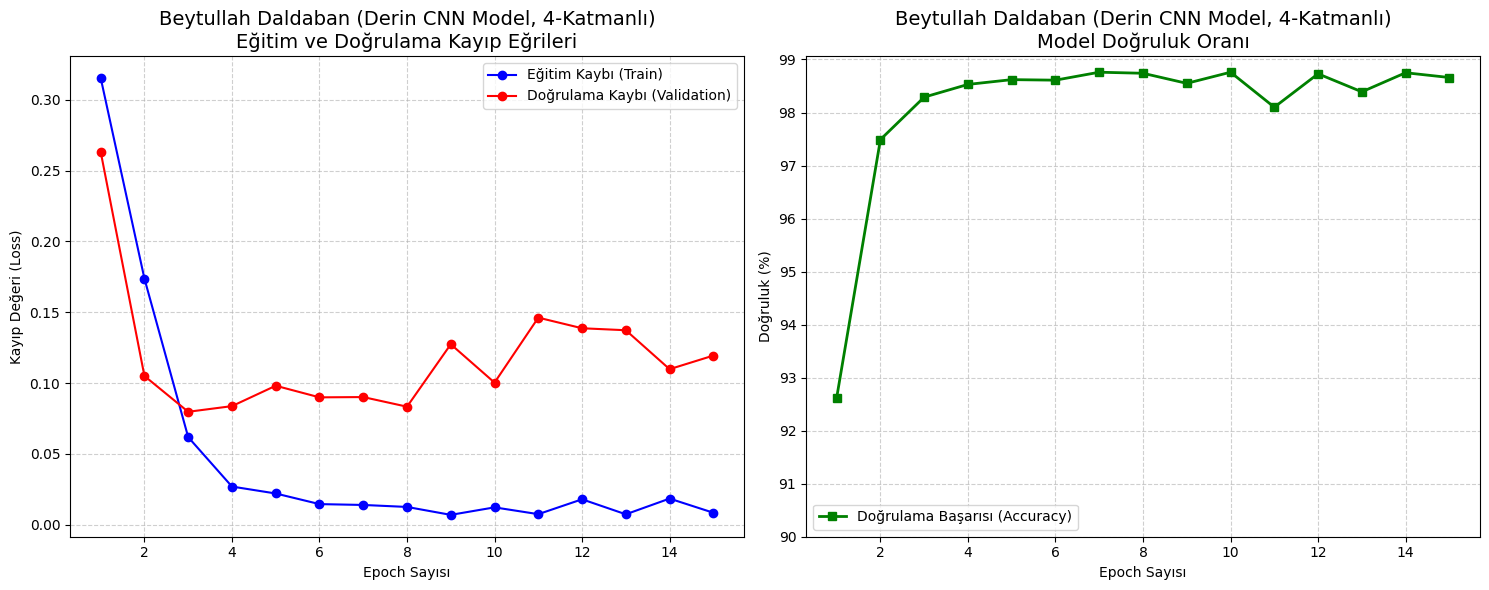

In [3]:
import matplotlib.pyplot as plt

USER_INFO = "Beytullah Daldaban (Derin CNN Model, 4-Katmanlı)"

epochs = list(range(1, 16))
train_losses = [0.3156, 0.1738, 0.0618, 0.0269, 0.0220, 0.0145, 0.0139, 0.0125, 0.0069, 0.0122, 0.0074, 0.0179, 0.0073, 0.0184, 0.0084]
val_losses = [0.2634, 0.1050, 0.0797, 0.0837, 0.0981, 0.0899, 0.0901, 0.0833, 0.1274, 0.1003, 0.1462, 0.1387, 0.1373, 0.1098, 0.1194]
accuracies = [92.62, 97.49, 98.29, 98.53, 98.62, 98.61, 98.76, 98.74, 98.55, 98.76, 98.10, 98.73, 98.39, 98.75, 98.66]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o', label='Eğitim Kaybı (Train)')
plt.plot(epochs, val_losses, 'r-o', label='Doğrulama Kaybı (Validation)')

plt.title(f'{USER_INFO}\nEğitim ve Doğrulama Kayıp Eğrileri', fontsize=14)

plt.xlabel('Epoch Sayısı')
plt.ylabel('Kayıp Değeri (Loss)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'g-s', linewidth=2, label='Doğrulama Başarısı (Accuracy)')

plt.title(f'{USER_INFO}\nModel Doğruluk Oranı', fontsize=14)

plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk (%)')
plt.yticks(range(90, 100, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()